# Non-radial Orbit Correction


In this notebook we will explore the use of an orbit loop up table to correct the implied distance and velocity by relaxing the assumption of radial orbits a bit. We will use the implied distance and radial velocity to search in the precomputed orbits parameter space for the best matching orbit. This orbit will have a velocity vector that will not perfectly align with the galactocentric position vector, meaning that the cross product:

$$ \vec{R} \times \vec{V} = \vec{\Omega} \neq 0 $$

Where $\Omega$ is some non-zero vector that can be computed using the snapshot of the orbit that more closely matches the source. Then:

$$
\bigl(\vec{V}_0 + V_r \,\hat{n} + D \,\vec{\mu}\bigr) \times
\bigl(\vec{R}_0 + D \,\hat{n}\bigr) = \vec{\Omega}.
$$

Taking the dot product with $ \vec{\mu} $ to find the deviation in the velocity, we get:

$$
\vec{\mu} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \vec{\mu} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
\vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D \,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- V_r \,\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})
= \vec{\mu} \cdot \vec{\Omega}.
$$

Solving for $ V_r $:

$$
V_r
= \frac{ \vec{\mu} \cdot (\vec{V}_0 \times \vec{R}_0)
+ D\,\vec{\mu} \cdot (\vec{V}_0 \times \hat{n})
- \vec{\mu} \cdot \vec{\Omega}
}{ \vec{\mu} \cdot (\vec{R}_0 \times \hat{n}) }.
$$

Therefore, if we call the purely radial solution $ \tilde{V}_r $, we get:

$$
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Similarly, taking the dot product with $ \hat{n} $ instead of $ \vec{\mu} $ to find the implied distance:

$$
\hat{n} \cdot \Bigl(
\vec{V}_0 \times \vec{R}_0
+ D \, (\vec{V}_0 \times \hat{n})
- V_r \, (\vec{R}_0 \times \hat{n})
+ D \, (\vec{\mu} \times \vec{R}_0)
+ D^2 \, (\vec{\mu} \times \hat{n})
\Bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Which simplifies to:

$$
(\hat{n} \times \vec{V}_0) \cdot \vec{R}_0
+ D \, \bigl((\hat{n} \times \vec{\mu}) \cdot \vec{R}_0\bigr)
= \hat{n} \cdot \vec{\Omega}.
$$

Solving for $ D $:

$$
D
= \frac{\hat{n} \cdot \vec{\Omega}
+ \hat{n} \cdot (\vec{R}_0 \times \vec{V}_0)}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Again, calling the radial solution $ \tilde{D}_I $, we get:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}
{ \vec{R}_0 \cdot \bigl(\hat{n} \times \vec{\mu}\bigr)}.
$$

Therefore, the correction to be applied if the trajectory is not strictly radial (given that $ \vec{\Omega} $ is known --- for example, from a lookup table of orbits that reach the current position with a total velocity similar to the source of interest) is as follows. One computes $ \vec{\Omega} $ for the realistic velocity vector, and then applies:

$$
D
= \tilde{D}_I
+ \frac{\hat{n} \cdot \vec{\Omega}}{\vec{R}_0 \cdot (\hat{n} \times \vec{\mu})},
\quad
V_r
= \tilde{V}_r
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

Note that if the deviation from a radial orbit is small (1st order perturbation) and given by a small angle $ \delta \alpha $, we will have:

$$
|\vec{\Omega}| = |\vec{R}||\vec{V}|\sin(\delta \alpha) \approx |\vec{R}||\vec{V}| \delta \alpha
$$


# Compute grid of orbits until apocenter

In [31]:
# imports
import agama
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
from tqdm import tqdm
import os
import sys
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt

# set current directory to /app/data so we can work with relative paths
os.chdir('/app/data/')

# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/')

from scripts import orbit_integration_agama as oia

#import agama
agama.setUnits(mass=1, length=1, velocity=1)

from matplotlib.ticker import MaxNLocator
# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})


In [32]:

def compute_orbit_to_first_apocenter( v_ej, theta_rad, phi_rad= 0, r_i= 3, potential_file='Agama/brown2015.pot', n_steps= None, n_steps_f = 1000):
    """
    Compute the orbit trajectory and velocities up to the first apocenter.

    Parameters:
        r_i (float): Initial radius in pc.
        v_ej (float): Ejection velocity in km/s.
        theta_rad (float): Angle from the Z-axis in radians.
        phi_rad (float): Angle from the X-axis to the projection in the galactic plane in radians.
        potential_file (str): Path to the potential file for the integration.
        t_step (float): Integration step in Gyr.

    Returns:
        tuple: Arrays of positions (x, y, z) and velocities (vx, vy, vz) up to the first apocenter.
    """
    # Load the potential
    potential = agama.Potential(file=potential_file)
    
    # Convert spherical to Cartesian coordinates
    x = r_i * np.sin(theta_rad) * np.cos(phi_rad)
    y = r_i * np.sin(theta_rad) * np.sin(phi_rad)
    z = r_i * np.cos(theta_rad)
    vx = v_ej * np.sin(theta_rad) * np.cos(phi_rad)
    vy = v_ej * np.sin(theta_rad) * np.sin(phi_rad)
    vz = v_ej * np.cos(theta_rad)
    
    # Define the initial state
    initial_state = np.array([x, y, z, vx, vy, vz])
    #print(initial_state)
    # check that inital state is an array of Nx6 of float values
    #assert isinstance(initial_state, np.ndarray), 'Initial state must be a numpy array'
    assert initial_state.shape == (6,), 'Initial state must have shape (6,)'
    if initial_state.dtype != np.float64:
        initial_state = initial_state.ravel()
    assert initial_state.dtype == np.float64, 'Initial state must be of type float64'
    
    # Integration settings
    t_max = (300 * u.kpc / (v_ej * u.km / u.s)).to(u.Gyr).value  
    # Max time is defined as the time it takes to
    #  reach the MW virial radius, in practice most objects will not get here but we can guarantee that
    #  all the orbit of interest will exist in this time. 
    
    # Integrate orbit
    # If n_steps is not None, set the trajectory size to n_steps
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize=n_steps)
    # If not, let Agama decide the trajectory size automatically using adaptive step size
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=t_max, dtype = object, trajsize= 0)#, trajsize=int(t_max/t_step))

    # Extract trajectory and velocities
    ts=np.array([t for t in orbit])
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    # Compute radial distances
    radial_distances = np.linalg.norm(positions, axis=1)

    # Find the first apocenter
    for i in range(1, len(radial_distances) - 1):
        if radial_distances[i] > radial_distances[i - 1] and radial_distances[i] > radial_distances[i + 1]:
            apocenter_index = i -1 # The apocenter is the point before the distance starts decreasing, that way the velocity nevere becomes less than zero
            break
    else:
        apocenter_index = len(radial_distances) - 1  # Default to the last point if no apocenter is found



    # Run the orbit again but only up to the first apocenter to get the same number of points for each orbit
    #This works but it might be better to let AGAMA decide on the spacing of the steps in the first orbit and then do it with steps for consistency
    if n_steps is not None:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=np.linspace(0, t_max, n_steps )[apocenter_index], dtype = object, trajsize=n_steps)
    else:
        orbit = agama.orbit(potential=potential, ic=initial_state, time=ts[apocenter_index], dtype = object, trajsize=n_steps_f)
    # Extract trajectory and velocities
    positions = orbit(orbit)[:, :3]
    velocities = orbit(orbit)[:, 3:]

    return positions, velocities, orbit


def doall(nsteps = 1000, N = 10000):
    seed = 3
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 4, size=N)
    cosa = rng.uniform(0, 1, size=N)
    x, y, z, vx, vy, vz = [], [], [], [], [], []
    orbit_interpolators = [] # this can be used if we want the time steps or other info on the orbit
    for i in tqdm(range(N)):
        pos, vel, orbit = compute_orbit_to_first_apocenter(vej[i], np.arccos(cosa[i]), n_steps_f=nsteps)
        x.append(pos[:,0])
        y.append(pos[:,1])
        z.append(pos[:,2])
        vx.append(vel[:,0])
        vy.append(vel[:,1])
        vz.append(vel[:,2])
        orbit_interpolators.append(orbit)

    return [np.array(_) for _ in [x, y, z, vx, vy, vz, vej, cosa, orbit_interpolators]]


In [33]:
x, y, z, vx, vy, vz, vej, cosa, orbits = doall(nsteps = 1000, N = 10000)

100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 538.47it/s]


# Check the sampling of the ejection parameters



In [4]:
import matplotlib
print(matplotlib.get_backend())
print(matplotlib.rcParams['text.usetex'])

module://matplotlib_inline.backend_inline
True


/tmp/ipykernel_17336/2038698617.py:6: RuntimeWarning: divide by zero encountered in log10
  return np.log10(v)


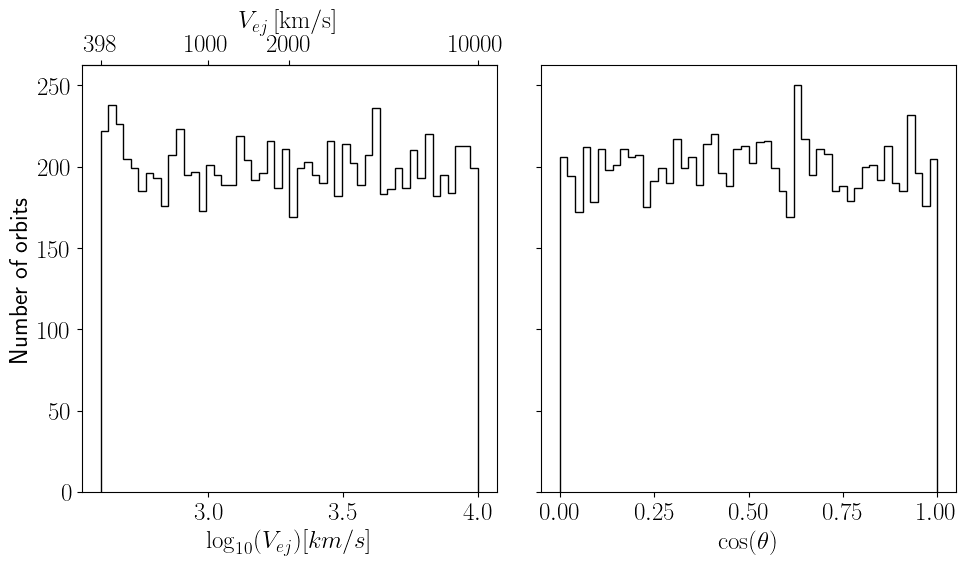

In [19]:
# Define functions
def log_to_velocity(x):
    return 10**x

def velocity_to_log(v):
    return np.log10(v)



fig, ax = plt.subplots(1,2, figsize=(10, 6), sharey=True)
ax[0].hist(np.log10(vej), bins=50, histtype='step', color='k')
ax[0].set_xlabel(r'$\log_{10}(V_{ej}) [km/s]$')
ax[0].set_ylabel(r'Number of orbits')
# add a second X axis on top showing the velocity without log scale
ax[0].set_axis_on()
ax[1].hist(cosa, bins=50, histtype='step', color='k')
ax[1].set_xlabel(r'$\cos(\theta)$')


# Add secondary X-axis for the first subplot
secax_0 = ax[0].secondary_xaxis('top', functions=(log_to_velocity, velocity_to_log))
secax_0.set_xlabel(r'$V_{ej} \, [\mathrm{km/s}]$')

# Reduce the number of ticks
#secax_0.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit to 5 ticks
secax_0.set_xticks([10**2.6, 1000, 2000, 10000, 100000])  # Set the ticks manually


#plt.tight_layout()
#plt.show()


plt.tight_layout()
plt.show()

# Check the orbits

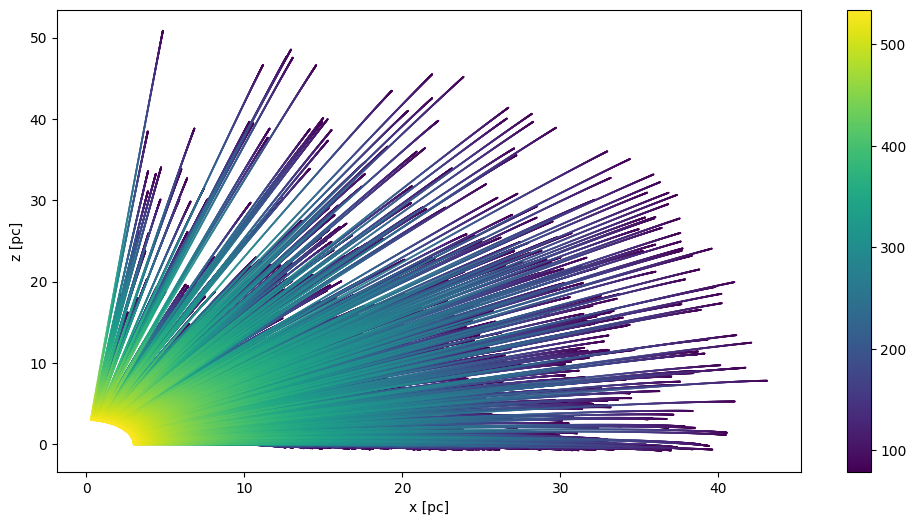

In [40]:
# lets see the first 100 orbits sorted by ejection velocity
mask  = np.argsort(vej)[:1000]

z_slow = z[mask]
x_slow = x[mask]
y_slow = y[mask]
z_slow = z[mask]
vx_slow = vx[mask]
vy_slow = vy[mask]
vz_slow = vz[mask]
vej_slow = vej[mask]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(1000):
    cbar = ax.scatter(x_slow[i], z_slow[i], c = (vx_slow[i]**2 + vz_slow[i]**2)**0.5,s = 0.1)
# add colorbar to see the velocities
plt.colorbar(cbar)
    #ax.scatter(R_slow[i], z_slow[i], c = np.tile(vej_slow[i], len(z_slow[i])), s = 0.1)
#plt.yscale('log')

plt.xlabel('x [pc]')
plt.ylabel('z [pc]')
plt.show()

We see that the orbit works to only get points from ejection until apocenter

# Try to replicate Sergey plot

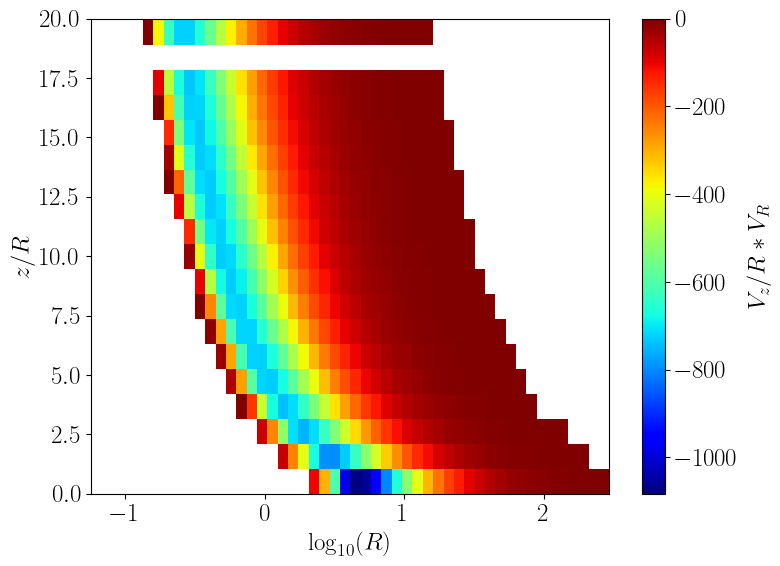

: 

In [ ]:
R_sergey = (x**2 + y**2)**0.5
VR_sergey = vx*R_sergey/x
Vz_sergey = vz - vx*z/x # I do not understand this line



# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

# Flatten to go from (10000, 1000) to (10000000,)
zf = z.flatten()
VRf = VR_sergey.flatten()
Vzf = Vz_sergey.flatten()
Rf = R_sergey.flatten()


from scipy.stats import binned_statistic_2d

# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y= zf/Rf, # to avoid log(0) we add a small number
    x=np.log10(Rf),
    values=Vzf/Rf*VRf,
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')#, vmin= 0, vmax= 2e3)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$V_z/R*V_R$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$z/R$')
#plt.title(r'')
plt.tight_layout()
plt.ylim(0, 20)
#plt.xlim(
# -2, 2)
plt.show()

# Compute $\Omega$ for each point in each orbit

This is absurdly easy to do since 

In [5]:
# compute Omega for each point in the orbit, in SI units
R_vector = np.array([x.flatten(), y.flatten(), z.flatten()]).T *u.kpc.to(u.meter)
V_vector = np.array([vx.flatten(), vy.flatten(), vz.flatten()]).T *(u.km/u.s).to(u.meter/u.s)
Omega_vector = np.cross(R_vector, V_vector, axis=-1) # This is now Omega(R, z, theta_ej, v_ej)

Omega_amplitude = Omega_vector[:,1] # Omega will always be in the Y direction, it is in meters

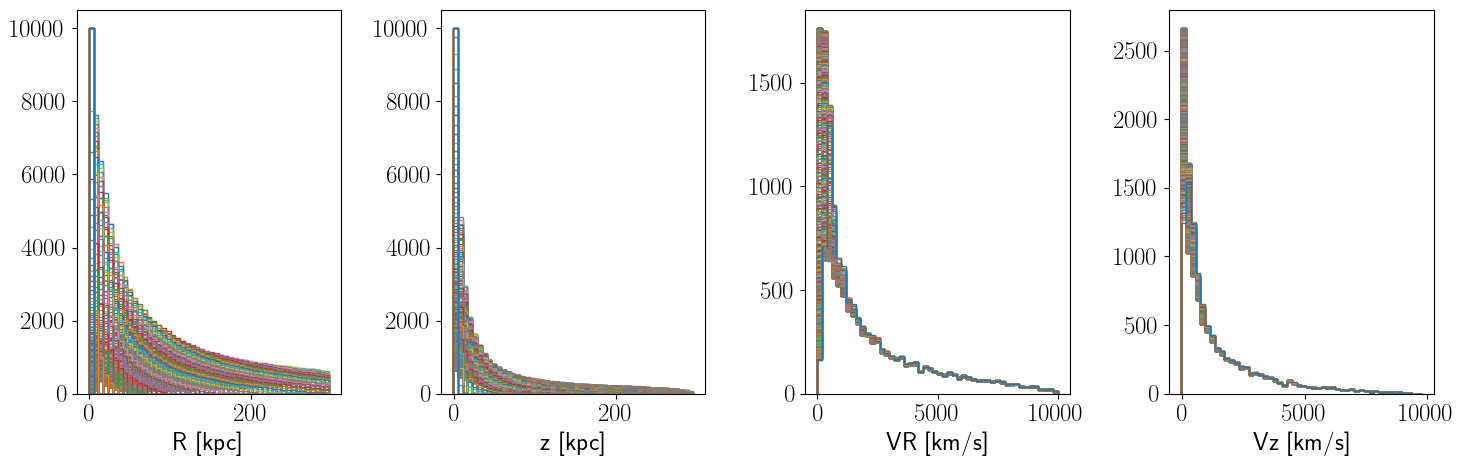

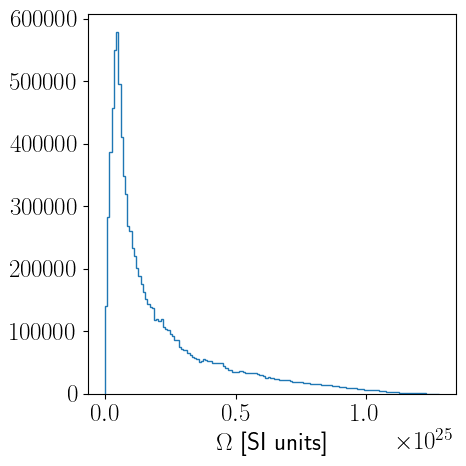

In [21]:
# see the distribution of the parameters
# plot histograms of all the parameters to know the range of interpolation
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].hist(x, bins=50, histtype='step')
ax[0].set_xlabel('R [kpc]')

ax[1].hist(z, bins=50, histtype='step')
ax[1].set_xlabel('z [kpc]')

ax[2].hist(vx, bins=50, histtype='step')
ax[2].set_xlabel('VR [km/s]')

ax[3].hist(vz, bins=50, histtype='step')
ax[3].set_xlabel('Vz [km/s]')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(Omega_amplitude, bins=150, histtype='step')
ax.set_xlabel('$\Omega$ [SI units]')
plt.tight_layout()
plt.show()

# See if I can drop any dimensions

In [63]:
from sklearn.decomposition import IncrementalPCA


# Reshape data to (num_orbits, points_per_orbit, dimensions)
data = np.stack((x, y, z, vx, vy, vz), axis=1).reshape(10000, 1000, 6)


# Incremental PCA 
ipca = IncrementalPCA(n_components=3, batch_size=10000)  # Adjust batch_size as needed
principal_components = ipca.fit_transform(data.reshape(-1, 6))

principal_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3'])

# Explained variance
explained_variance = ipca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Cumulative explained variance:", np.cumsum(explained_variance))


Explained variance ratio: [9.98364431e-01 1.28953054e-03 3.46035299e-04]
Cumulative explained variance: [0.99836443 0.99965396 1.        ]


In [62]:
principal_df.tail()

,PC1,PC2,PC3
9999995,-365.847603,1.317871,-1.995376
9999996,-365.850238,1.317876,-1.995372
9999997,-365.852849,1.317880,-1.995369
9999998,-365.855435,1.317884,-1.995366
9999999,-365.857998,1.317889,-1.995362


# Grid data to make interpolator smaller

In [44]:
# zf = z.flatten()
# #VRf = VR.flatten()
# Vtot_f =( (vx**2 + vy**2 + vz**2)**0.5).flatten()
# Rf = (z**2 + x**2+ y**2).flatten()

# print(zf.shape, Vtot_f.shape, Rf.shape, Omega_amplitude.shape)

zf = z.flatten()
Vzf = vz.flatten()
Vxf = vx.flatten()

Vtot_f = np.array([np.sqrt(vx[i]**2 + vy[i]**2 + vz[i]**2) for i in range(len(vx))]).flatten()
Rf = np.array([np.sqrt(x[i]**2 + y[i]**2 + z[i]**2) for i in range(len(x))]).flatten()

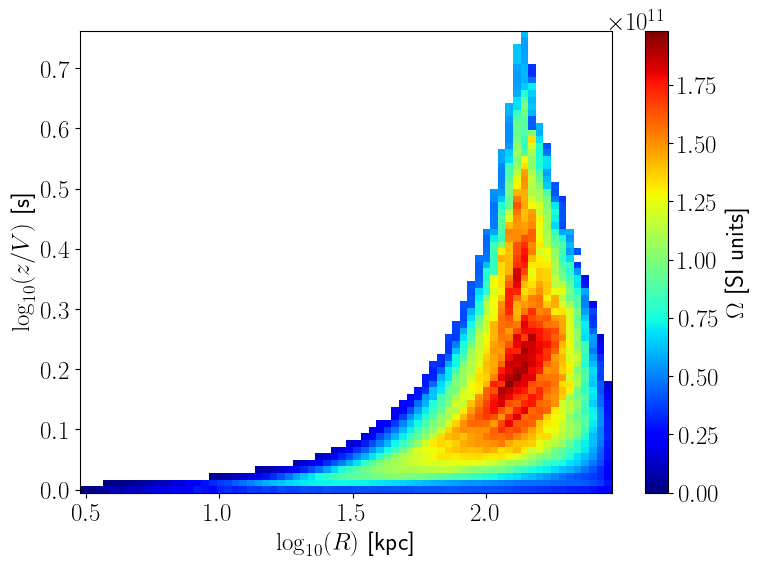

In [69]:

from scipy.stats import binned_statistic_2d


# Choose how many bins you want in each dimension
xbins = 70  # bins in z
ybins = 70  # bins in log10(VR)

#zf = z.flatten()
#VRf = VR.flatten()
#Vtot_f = ((vx**2 + vy**2 + vz**2)**0.5).flatten()
#Rf = (z**2 + x**2).flatten()



# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y=zf/Vtot_f,
    x=np.log10(Rf),
    values=np.abs(Omega_amplitude)*u.meter.to(u.mpc),
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')#, vmin= 0, vmax= 2e3)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$\Omega$ [SI units] ')

plt.xlabel(r'$\log_{10}(R)$ [kpc]')
plt.ylabel(r'$\log_{10}(z/V)$ [s]')
#plt.title(r'')
#plt.yscale('symlog')
plt.tight_layout()
#plt.xlim(-2, 2)
#plt.ylim(0, 0.3)
#plt.yscale('log')
plt.show()

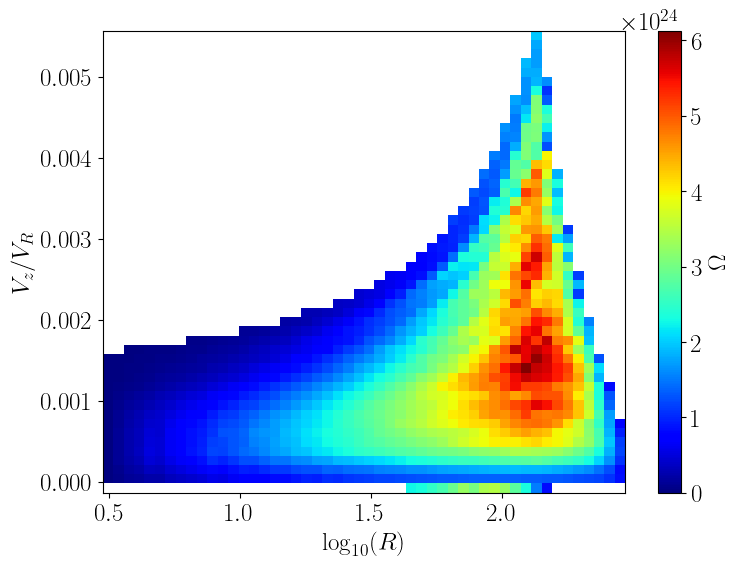

In [72]:

# Choose how many bins you want in each dimension
xbins = 50  # bins in z
ybins = 50  # bins in log10(VR)

#zf = z.flatten()
VRf = (vx**2 + vz**2).flatten()
#Vzf = Vz.flatten()
#Rf = R.flatten()



# Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
# statistic='mean' can also be 'median', 'count', 'sum', etc.
stat, xedges, yedges, binnum = binned_statistic_2d(
    y=Vzf/VRf,
    x=np.log10(Rf),
    values=np.abs(Omega_amplitude) +10 ,
    statistic='mean',
    bins=[xbins, ybins]
)

# 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
# We can plot it with pcolormesh (or imshow).
plt.figure(figsize=(8, 6))
# Note that stat is indexed as stat[ix, iy], but pcolormesh expects
# xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
# along the vertical axis, so we transpose 'stat' in pcolormesh.
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')#, vmin= 0, vmax= 2e3)

# Colorbar labeling
cb = plt.colorbar()
cb.set_label(r'$\Omega$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$V_z/V_R$')
#plt.title(r'')
plt.tight_layout()
#plt.xlim(-2, 2)
plt.show()

In [50]:
zf = z.flatten()
xf = x.flatten()


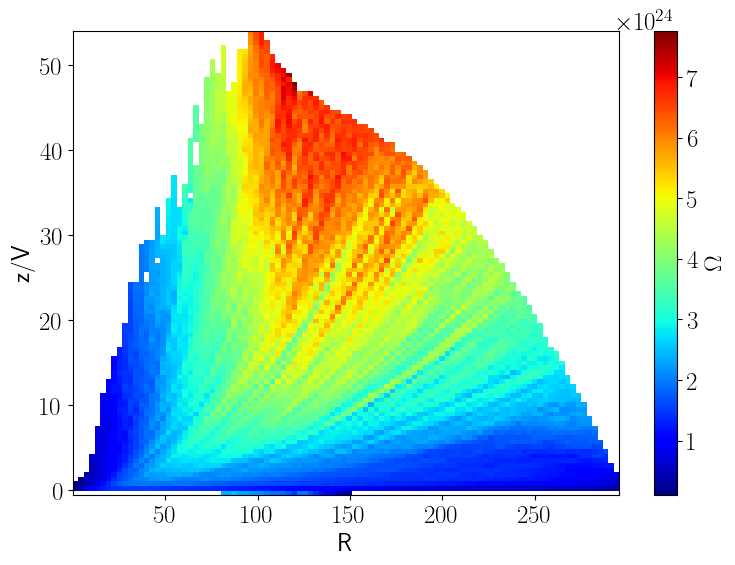

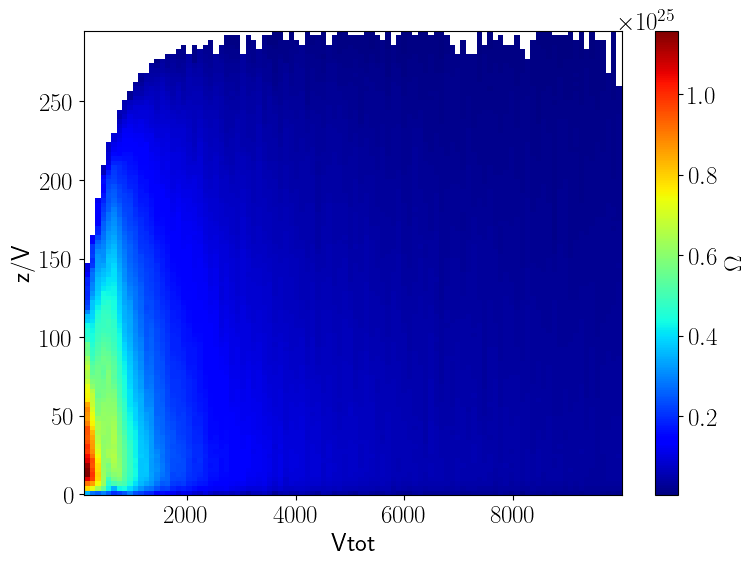

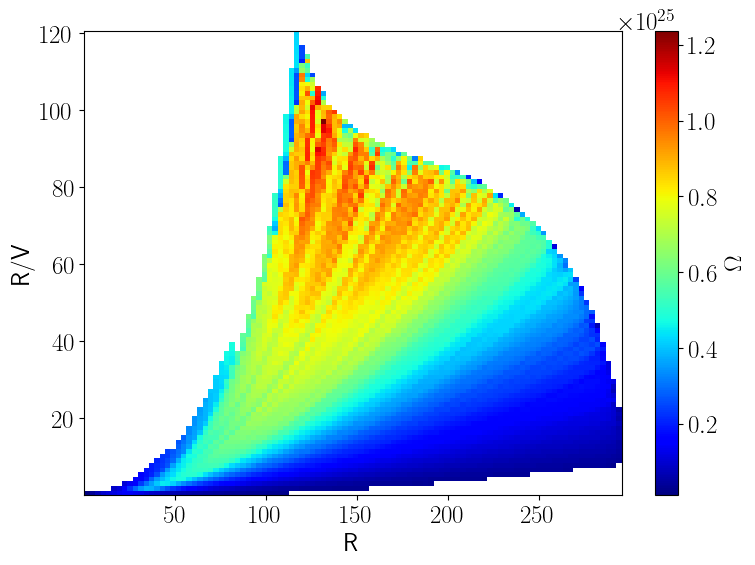

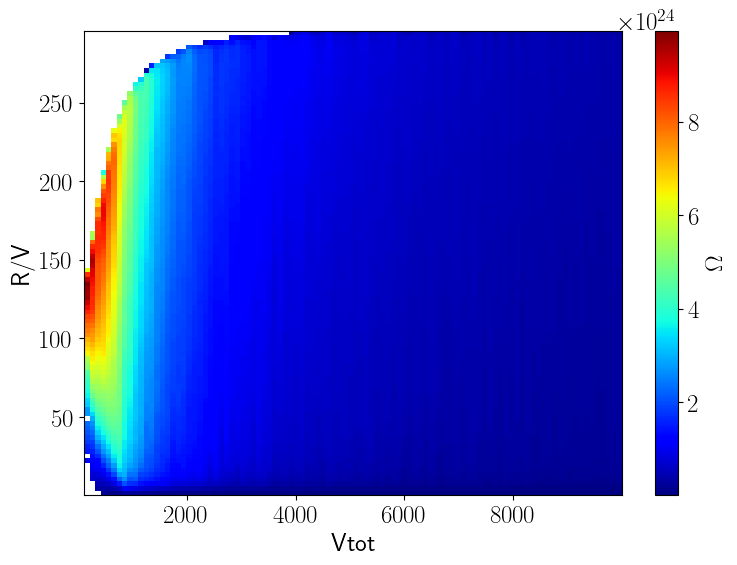

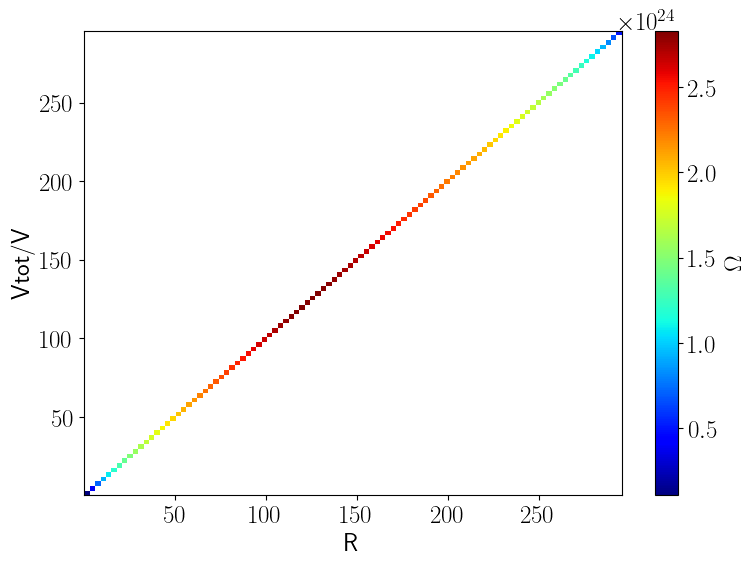

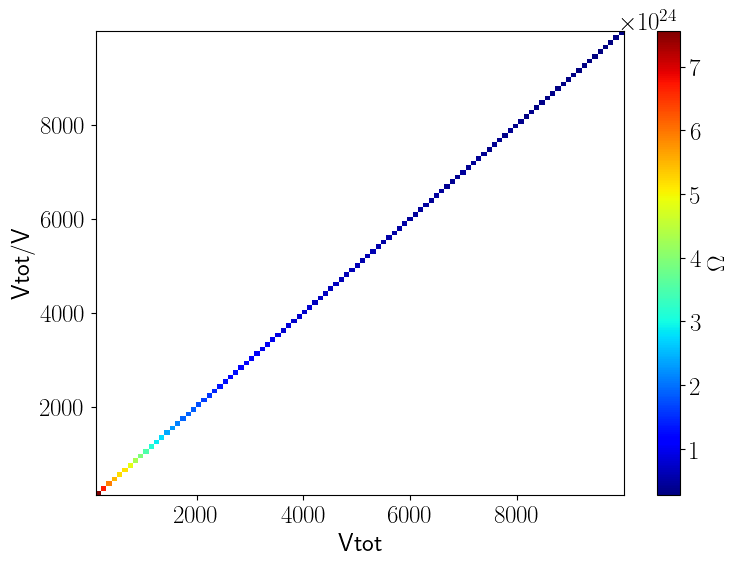

In [70]:
# plot a combination of the parameters to see the 2D statistic in a search for a paremeter space that allows us to bin the data without losin information
# Choose how many bins you want in each dimension
xbins = 100  # bins in z
ybins = 100  # bins in log10(VR)

for par, label in zip([zf, xf, Vtot_f], ['z', 'R', 'Vtot']):
    for parx, labelx in zip([ xf, Vtot_f], ['R', 'Vtot']):
        #if parx is par:
        #    continue  

        # Use binned_statistic_2d to compute the mean ratio in each (z, logVR) bin
        # statistic='mean' can also be 'median', 'count', 'sum', etc.
        stat, xedges, yedges, binnum = binned_statistic_2d(
            y=par*parx/Vtot_f,
            x=parx,
            values=np.abs(Omega_amplitude),
            statistic='mean',
            bins=[xbins, ybins]
        )

        # 'stat' is a 2D array of the same shape as bins: (xbins, ybins)
        # We can plot it with pcolormesh (or imshow).
        plt.figure(figsize=(8, 6))
        # Note that stat is indexed as stat[ix, iy], but pcolormesh expects
        # xedges (length xbins+1) along the horizontal axis, yedges (length ybins+1)
        # along the vertical axis, so we transpose 'stat' in pcolormesh.
        plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')#, vmin= 0, vmax= 2e3)

        # Colorbar labeling
        cb = plt.colorbar()
        cb.set_label(r'$\Omega$ ')

        plt.xlabel(labelx)
        plt.ylabel(label+'/V')
        #plt.title(r'')
        plt.tight_layout()
        #plt.xlim(-2, 2)
        plt.show()

# Construct interpolator

The goal of this interpolator is given a current positon of a source in cylindrical coordinates and the total velocity, return the corresponding magntiude of $\Omega$. Then the correction term can be calculated.

In [10]:
from logging import warn
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import LinearNDInterpolator

class OrbitInterpolator2D:
    def __init__(self, R, z, Vtot, Omega):
        """
        Initialize the interpolator with precomputed orbit data.

        Parameters:
        - R, z, VR, Vz, t: 2D arrays of shape (n_orbits, n_points_per_orbit).
        """
        # Flatten the data
        self.R = R.flatten()
        self.z = z.flatten()
        # self.V = V.flatten()
        # self.Vz = Vz.flatten()
        self.Vtot =   Vtot.flatten() #np.sqrt(self.VR**2 + self.Vz**2) # I will try to use the total velocity instead of splitting in RZ components

        # Omega should be a flattened array of just the Y component
        self.Omega = Omega 
        #assert np.all(self.Omega >= 0), "All Omega values should be positive!" # seems that Omega can be negative ups


        # Create a KDTree for efficient nearest-neighbor search
        self.tree = cKDTree(np.column_stack((self.R, self.z, self.Vtot)))

        # Create an interpolator for Vz
        self.interpolator = LinearNDInterpolator(
            np.column_stack((self.R, self.z, self.Vtot)),
            self.Omega
        )
    
    # def query(self, R, z, Vtot):
    #     """
    #     Query the interpolator to find Vz for a given R, z, and total velocity.

    #     Parameters:
    #     - R, z, Vtot: Input parameters to match.

    #     Returns:
    #     - Interpolated Vz value.
    #     """
    #     # Try to interpolate Vz
    #     Omega_interp = self.interpolator(R, z, Vtot)
    #     if np.isnan(Omega_interp):  # Fall back to nearest neighbor
    #                 # Find the nearest neighbor if interpolation fails
    #         dist, idx = self.tree.query([R, z, Vtot])
    #         Omega_nearest = self.Omega[idx]
    #         #warn(f"Interpolation failed at R={R:.2f}, z={z:.2f}, V={Vtot:.2f}! Using nearest neighbor instead.")
    #         return Omega_nearest
    #     return Omega_interp
    
    def query(self, R, z, Vtot):
        """
        Vectorized query for arrays of (R, z, Vr, Vz).

        Parameters
        ----------
        R, z, Vr, Vz : array-like
            Arrays of R, z, V_r, V_z values to interpolate.

        Returns
        -------
        Omega_interp : ndarray
            Interpolated Omega values for each point in (R, z, Vr, Vz).
        """
        # Ensure inputs are NumPy arrays
        R = np.asarray(R)
        z = np.asarray(z)
        Vtot = np.asarray(Vtot)
        
        # Interpolate all points in one go
        Omega_interp = self.interpolator(R, z, Vtot)

        # Identify where the interpolation failed (NaNs)
        nan_mask = np.isnan(Omega_interp)

        if np.any(nan_mask):
            # Gather all points that resulted in NaN
            points_nan = np.column_stack((R[nan_mask], z[nan_mask], Vtot[nan_mask]))

            # Query the KDTree for these NaN points in a single batch
            dist, idx = self.tree.query(points_nan)

            # Replace the NaN values with the nearest neighbor values
            Omega_interp[nan_mask] = self.Omega[idx]

        return Omega_interp


In [11]:

class Omega_interpolator_t:
    def __init__(self, R, z, Vr, Vz, Omega):
        """
        Initialize the interpolator with precomputed orbit data. R referers to cylindrical radius, 
        z to height above the plane, Vtot to the total velocity and Omega is RxV in SI units.

        Here we will test if the interpolator works with the 4D data, and if it can interpolate the Omega values
        since if we try to do it with only R, Z and Vtot it seems to fail or give wrong values.

        Parameters:
        - R, z, VR, Vz, t: 2D arrays of shape (n_orbits, n_points_per_orbit).

        """
        # Flatten the data
        self.R = R.flatten()
        self.z = z.flatten()
        self.Vr = Vr.flatten()
        self.Vz = Vz.flatten()
        #self.Vtot =   Vtot.flatten() #np.sqrt(self.VR**2 + self.Vz**2) # I will try to use the total velocity instead of splitting in RZ components

        # Omega should be a flattened array of just the Y component
        self.Omega = Omega 
        #assert np.all(self.Omega >= 0), "All Omega values should be positive!" # seems that Omega can be negative ups


        # Create a KDTree for efficient nearest-neighbor search
        self.tree = cKDTree(np.column_stack((self.R, self.z, self.Vr, self.Vz)))

        # Create an interpolator for Vz
        self.interpolator = LinearNDInterpolator(
            np.column_stack((self.R, self.z, self.Vr, self.Vz)),
            self.Omega
        )
    
    # def query(self, R, z, Vr, Vz):
    #     """
    #     Query the interpolator to find Vz for a given R, z, and total velocity.

    #     Parameters:
    #     - R, z, Vtot: Input parameters to match.

    #     Returns:
    #     - Interpolated Vz value.
    #     """
    #     # Try to interpolate Vz
    #     Omega_interp = self.interpolator(R, z, Vr, Vz)
    #     if np.isnan(Omega_interp):  # Fall back to nearest neighbor
    #                 # Find the nearest neighbor if interpolation fails
    #         dist, idx = self.tree.query([R, z, Vr, Vz])
    #         Omega_nearest = self.Omega[idx]
    #         #warn(f"Interpolation failed at R={R:.2f}, z={z:.2f}, V={Vtot:.2f}! Using nearest neighbor instead.")
    #         return Omega_nearest
    #     return Omega_interp
    # import numpy as np

    def query(self, R, z, Vr, Vz):
        """
        Vectorized query for arrays of (R, z, Vr, Vz).

        Parameters
        ----------
        R, z, Vr, Vz : array-like
            Arrays of R, z, V_r, V_z values to interpolate.

        Returns
        -------
        Omega_interp : ndarray
            Interpolated Omega values for each point in (R, z, Vr, Vz).
        """
        # Ensure inputs are NumPy arrays
        R = np.asarray(R)
        z = np.asarray(z)
        Vr = np.asarray(Vr)
        Vz = np.asarray(Vz)
        
        # Interpolate all points in one go
        Omega_interp = self.interpolator(R, z, Vr, Vz)

        # Identify where the interpolation failed (NaNs)
        nan_mask = np.isnan(Omega_interp)

        if np.any(nan_mask):
            # Gather all points that resulted in NaN
            points_nan = np.column_stack((R[nan_mask], z[nan_mask], Vr[nan_mask], Vz[nan_mask]))

            # Query the KDTree for these NaN points in a single batch
            dist, idx = self.tree.query(points_nan)

            # Replace the NaN values with the nearest neighbor values
            Omega_interp[nan_mask] = self.Omega[idx]

        return Omega_interp



In cylindrical coordinates R = x and z = z. There is no component of y in R since we set every orbit to be in the x-z plane. So now we need a function that computes the correction term:


# 3 dimensional Interpolator

Here I will test if it is possible to construct the interpolator only using the cylindrical R coordinate, Z coordinate and total velocity to obtain $\Omega$. This drop in dimensionality from the full 3D position and velocity would make this interpolation more precise and less computationally expensive. However, it relies on the assumption that for any given R, z and total velocity V, there is only 1 orbit that will cross this position with the correct total velocity. 

In [9]:
# Create the interpolator for orbital points between 8 and 9 kpc in Galactocentric radius
R_GC = (x**2 + z**2)**0.5
mask = (R_GC > 8) & (R_GC < 15)
R_sub = R_GC[mask]
x_sub = x[mask]
z_sub = z[mask]
vx_sub = vx[mask]
vz_sub = vz[mask]
V_tot = (vx**2 + vz**2)**0.5
V_tot_sub = V_tot[mask]
# Omega is flattened, make it non-flattened for the mask
Omega_non_flat = Omega_amplitude.reshape(x.shape)
Omega_sub = Omega_non_flat[mask]
# Create the interpolator
omega_interpolator = OrbitInterpolator2D(x_sub, z_sub, V_tot_sub, Omega_sub)

NameError: name 'x' is not defined

In [ ]:
from sklearn.decomposition import IncrementalPCA


# Reshape data to (num_orbits, points_per_orbit, dimensions)
data = np.stack((x, z, V_tot), axis=1).reshape(10000, 1000, 3)


# Incremental PCA 
ipca = IncrementalPCA(n_components=3, batch_size=10000)  # Adjust batch_size as needed
ipca.fit(data.reshape(-1, 6))

# Explained variance
explained_variance = ipca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Cumulative explained variance:", np.cumsum(explained_variance))


Explained variance ratio: [9.98394885e-01 1.60165567e-03 3.45492147e-06]
Cumulative explained variance: [0.99839489 0.99999654 1.        ]


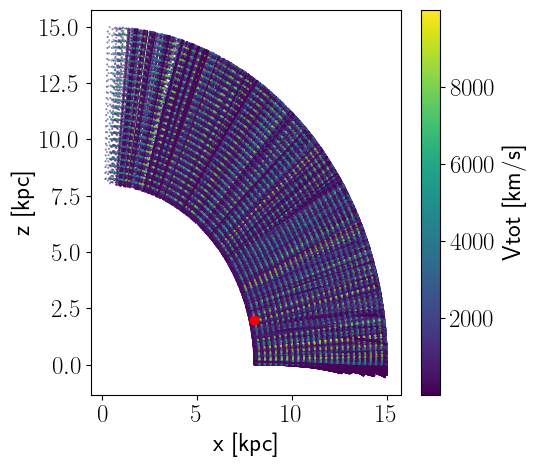

In [38]:
#
test_point = (8, 2, 500)
# plot interpolation range
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cbar = ax.scatter(x_sub, z_sub, c= V_tot_sub, s=0.1)
plt.colorbar(cbar, label='Vtot [km/s]')
ax.scatter(*test_point[:2], c='red', label='Test point')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.show()

In [39]:
print('Interpolation range in x:', x_sub.min(), x_sub.max())
print('Interpolation range in z:', z_sub.min(), z_sub.max())
print('Interpolation range in V:', V_tot_sub.min(), V_tot_sub.max())

Interpolation range in x: 0.15826114046597353 14.999866667266582
Interpolation range in z: -0.5484141145909595 14.975728329514498
Interpolation range in V: 26.302755778810127 9994.405995976


In [40]:
omega_interpolator.query(*test_point)

array(3.60880095e+24)

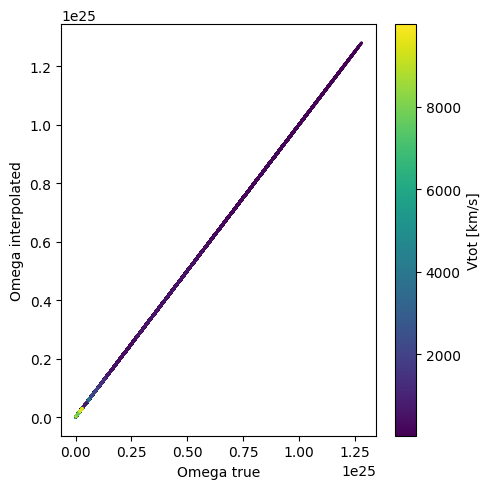

In [48]:
# check the interpolation by querying the interpolator with the same points used to create it
Omega_interp = np.zeros_like(R_sub)
for i in range(len(R_sub)):
    Omega_interp[i] = omega_interpolator.query(x_sub[i], z_sub[i], V_tot_sub[i])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cbar = ax.scatter(Omega_sub, Omega_interp, c = V_tot_sub, s=1)
plt.colorbar(cbar, label='Vtot [km/s]')
ax.set_xlabel('Omega true')
ax.set_ylabel('Omega interpolated')
plt.tight_layout()
plt.show()

In [10]:
import pickle
import os
import numpy as np

# Ensure the folder exists
output_folder = "Data/omega_interpolator_3d"
os.makedirs(output_folder, exist_ok=True)

# Calculate the radius (R_GC)
R_GC = (x**2 + z**2)**0.5

# Define the number of bins
num_bins = 20

# Compute quantile-based bin edges
quantile_edges = np.percentile(R_GC, np.linspace(0, 100, num_bins + 1))

# Function to create and save interpolators for given radius ranges
for i in range(7, num_bins):
    r_min = quantile_edges[i]  # Lower edge of the bin
    r_max = quantile_edges[i + 1]  # Upper edge of the bin

    # Create the mask for points within the radius range
    mask = (R_GC > r_min) & (R_GC <= r_max)

    # Subset the data based on the mask
    R_sub = R_GC[mask]
    x_sub = x[mask]
    z_sub = z[mask]
    vx_sub = vx[mask]
    vz_sub = vz[mask]
    V_tot = (vx**2 + vz**2)**0.5
    V_tot_sub = V_tot[mask]
    Omega_non_flat = Omega_amplitude.reshape(x.shape)
    Omega_sub = Omega_non_flat[mask]

    # Create the interpolator
    omega_interpolator = OrbitInterpolator2D(x_sub, z_sub, V_tot_sub, Omega_sub)

    # Save the interpolator to a file
    file_path = os.path.join(output_folder, f"interpolator_{r_min:.1f}-{r_max:.1f}kpc.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(omega_interpolator, f)

    # Optionally print bin info for debugging
    print(f"Bin {i + 1}: {len(R_sub)} points, range: [{r_min:.2f}, {r_max:.2f}] kpc")


Bin 8: 1000000 points, range: [173.86, 207.42] kpc


: 

: 

: 

# Full 4D interpolator

This should 100% give the correct result as we are passing all phase space information for the source, therefore, we are fixing 2 phase space points. The initial condition  ( ejection from the galactic center) and the current condition at a certain time t of the current position and velocity. 

This should be more robust, but a lot more computationally expensive, as each dimension we add will make the problem harder

With total velocity it seems to overestimate $\Omega$, so lets try with 4 dimensions. Or other parameter combinations


In [98]:
# 4 dimensions
omega_interpolator = Omega_interpolator_t(x_sub, z_sub, vx_sub, vz_sub, Omega_sub)

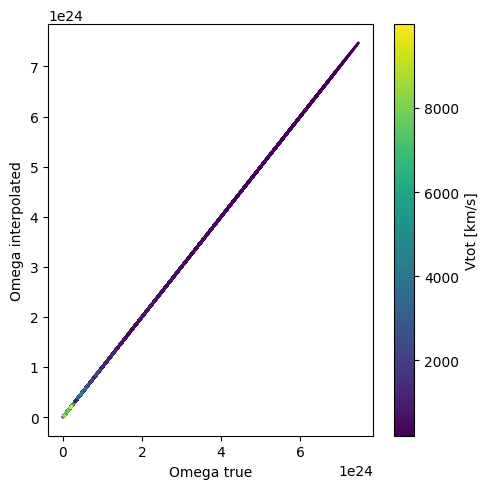

In [99]:
# check the interpolation by querying the interpolator with the same points used to create it
Omega_interp = np.zeros_like(R_sub)
for i in range(len(R_sub)):
    Omega_interp[i] = omega_interpolator.query(x_sub[i], z_sub[i], vx_sub[i], vz_sub[i])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cbar = ax.scatter(Omega_sub, Omega_interp, c = V_tot_sub, s=1)
plt.colorbar(cbar, label='Vtot [km/s]')
ax.set_xlabel('Omega true')
ax.set_ylabel('Omega interpolated')
plt.tight_layout()
plt.show()

The interpolator seems to work just fine. This means I can now create about 297 interpolators in radius bins from 3 kpc to 300 kpc. And save those as pickle files that can then be loaded when querying a specific source. 

In [ ]:
import pickle

# Ensure the folder exists
output_folder = "Data/omega_interpolator_4d"
os.makedirs(output_folder, exist_ok=True)

# Function to create and save interpolators for given radius ranges
for i in range(297):
    r_min = 12 + i  # Starting radius of the range
    r_max = r_min + 1  # Ending radius of the range

    # Create the mask for points within the radius range
    R_GC = (x**2 + z**2)**0.5
    mask = (R_GC > r_min) & (R_GC <= r_max)

    # Subset the data based on the mask
    R_sub = R_GC[mask]
    x_sub = x[mask]
    z_sub = z[mask]
    vx_sub = vx[mask]
    vz_sub = vz[mask]
    V_tot = (vx**2 + vz**2)**0.5
    V_tot_sub = V_tot[mask]
    Omega_non_flat = Omega_amplitude.reshape(x.shape)
    Omega_sub = Omega_non_flat[mask]

    # Create the interpolator
    omega_interpolator = Omega_interpolator_t(x_sub, z_sub, vx_sub, vz_sub, Omega_sub)

    # Save the interpolator to a file
    file_path = os.path.join(output_folder, f"interpolator_{r_min:.0f}-{r_max:.0f}kpc.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(omega_interpolator, f)


In [80]:
min(Omega_amplitude)

np.float64(-274877906944.0)

# Iterative correction

Now that we have a way to obtain $\Omega$ we need to implement the correction. This should be a new function that only returns the correction term. 

$$
D_{c}
=  \frac{\hat{n} \cdot \vec{\Omega}}{\vec{R}_0 \cdot (\hat{n} \times \vec{\mu})},
\quad
V_{c}
=
- \frac{\vec{\mu} \cdot \vec{\Omega}}{\vec{\mu} \cdot (\vec{R}_0 \times \hat{n})}.
$$

In [12]:
# imports 
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from numba import njit
from astropy.table import Table
import os
import astropy
import pandas as pd
from tqdm import tqdm

# Define the vectors that are constant for the Milky Way
def compute_R0_V0_SI():
    """
    Define the position and velocity of the Galactic Center in Galactocentric frame
    Here, we're using the position of the Sun in the Galactocentric frame,
    which by definition is at (x, y, z) = (0, 0, 0) in Galactocentric coordinates.
    We then transform this to the ICRS frame to get the position and velocity vectors.

    input:
        None
    output:
        R0: position vector pointing from the Galactic Center to the Sun in ICRS frame
        V0: velocity vector of the Sun in ICRS frame
    """
    galcen_coord = coord.Galactocentric(
        x=0 * u.kpc,
        y=0 * u.kpc,
        z=0 * u.kpc,
        v_x=0 * u.km / u.s,
        v_y=0 * u.km / u.s,
        v_z=0 * u.km / u.s
    )
    # Transform to ICRS frame
    icrs_coord = galcen_coord.transform_to(coord.ICRS())
    # Get the position and velocity in ICRS frame (in SI units)
    X0 = icrs_coord.cartesian.xyz.to(u.m).value  # position in meters
    V0 = icrs_coord.velocity.d_xyz.to(u.m / u.s).value  # velocity in m/s

    # Get the vector pointing from the Galactic Center to the Sun in ICRS frame
    R0 = -X0  # Shape (3,)
    V0 = -V0  # Shape (3,)
    return R0, V0


def cross_2D(a, b):
    """
    Vectorized cross product for two arrays of shape (N,3),
    returning shape (N,3).
    """
    return np.column_stack((
        a[:,1]*b[:,2] - a[:,2]*b[:,1],
        a[:,2]*b[:,0] - a[:,0]*b[:,2],
        a[:,0]*b[:,1] - a[:,1]*b[:,0]
    ))

def dot_2D(a, b):
    """
    Vectorized dot product for two arrays of shape (N,3),
    returning shape (N,).
    """
    return a[:,0]*b[:,0] + a[:,1]*b[:,1] + a[:,2]*b[:,2]

def compute_extra_term(R0, mu, n, Vz, ez):
    """
    Computes the correction term for the implied distance by considering a velocity component in the galactic Z direction

    Parameters:
        R0 (array): Vector from the galactic center to the sun in the ICRS coordinate system and SI units
        mu (array): Proper motion of the star in the ICRS coordinate system and SI units
        n (array): Normal vector from the sun to the source in the ICRS coordinate system (unit vector, from RA, DEC)
        Vz (float): Velocity component in the galactic Z direction in SI units
        ez (array): Unit vector in the galactic Z direction (orthogonal to the plane of the disk) in the ICRS coordinate system
    
    Returns:
        float: The correction term for the implied distance
    """
    r0xez = cross_2D(R0, ez)
    n_r0xez = dot_2D(n, r0xez)
    r0xmu = cross_2D(R0, mu)
    n_r0xmu = dot_2D(n, r0xmu)

    return Vz*(n_r0xez / n_r0xmu )

def extra_term_o(Omega, n, mu, R0):
    return np.dot(n, Omega)/np.dot(R0, np.cross(n, mu))

def extra_term_vectorized(Omega, n, mu, R0):
    return dot_2D(n, Omega) / dot_2D(R0, cross_2D(n, mu))

In [13]:
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
import astropy.units as u
import astropy.coordinates as coord
R0_SI, V0_SI = compute_R0_V0_SI()
def z_rotation(vector,theta):
    """Rotates 3-D vector around z-axis"""
    R = np.array([[np.cos(theta), -np.sin(theta),0],[np.sin(theta), np.cos(theta),0],[0,0,1]])
    return np.dot(R,vector)

def z_rotation_2d(theta):
    """
    Returns the 3x3 rotation matrix for a rotation around the z-axis by angle `theta`.
    Note this can handle array `theta` using broadcasting if carefully shaped.
    """
    # If theta is an array of shape (N,), we want an array of shape (N,3,3).
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    # We'll build a stack of rotation matrices
    if isinstance(theta, float):
        R = np.zeros((1, 3, 3))
    else:
        R = np.zeros((len(theta), 3, 3))
    R[:,0,0] = cos_t
    R[:,0,1] = -sin_t
    R[:,1,0] = sin_t
    R[:,1,1] = cos_t
    R[:,2,2] = 1.0
    return R

def compute_distance_correction(ra, dec, omega, R0, pmra, pmdec, D_i):
    """
    Compute distance correction using the sources ra, dec coordinates to define the n vector, pmra, pmdec for the mu vector.

    The Omega vector needs to be defined from the amplitude omega that is passed, which corresponds to the Y
    component of the Omega vector if the trajectory is in the XZ plane. Otherwise it needs to be rotated to align with 
    the plane of the orbit. 

    For consistency all vectors should be in SI units and in the ICRS frame.

    input:
        ra: right ascension in degrees (float or array)
        dec: declination in degrees 
        omega: amplitude of the Omega vector in SI units
        R0: position vector pointing from the Galactic Center to the Sun in ICRS frame
        pmra: proper motion in right ascension in mas/yr
        pmdec: proper motion in declination in mas/yr
        D_i: initial distance in pc
    """

        # Convert positions to radians
    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec)

    # Convert proper motions to radians per second
    masyr_to_radsec = (1 * u.mas / u.yr).to(u.rad / u.s).value
    pmra_rad_s = pmra * masyr_to_radsec
    pmdec_rad_s = pmdec * masyr_to_radsec

    # Initialize the arrays
    if isinstance(ra, float):
        N = 1
        plx = np.empty(1)
        eplx = np.empty(1)
        VGCR = np.empty(1)
        VR = np.empty(1)
    else:
        N = len(ra_rad)
        plx = np.empty(N)
        eplx = np.empty(N)
        VGCR = np.empty(N)
        VR = np.empty(N)

    R02 = np.sum(R0**2)
    #V0R0 = np.dot(V0, R0)


    ra_r = ra_rad
    dec_r = dec_rad

    cos_ra = np.cos(ra_r)
    sin_ra = np.sin(ra_r)
    cos_dec = np.cos(dec_r)
    sin_dec = np.sin(dec_r)

    # Compute the unit vector n
    n0 = cos_ra * cos_dec
    n1 = sin_ra * cos_dec
    n2 = sin_dec

    # pmra basis vector
    e10 = -sin_ra
    e11 = cos_ra
    e12 = 0.0

    # pmdec basis vector
    e20 = -cos_ra * sin_dec
    e21 = -sin_ra * sin_dec
    e22 = cos_dec
    
    # proper motions in rad/s (already converted)
    mu0 = pmra_rad_s * e10 + pmdec_rad_s * e20
    mu1 = pmra_rad_s * e11 + pmdec_rad_s * e21
    mu2 = pmra_rad_s * e12 + pmdec_rad_s * e22

    # Cross product of R0 and n
    R0n0 = n1 * R0[2] - n2 * R0[1]
    R0n1 = - (n0 * R0[2] - n2 * R0[0])
    R0n2 = n0 * R0[1] - n1 * R0[0]

    # Dot product of R0xn and mu
    R0xn_mu = mu0 * R0n0 + mu1 * R0n1 + mu2 * R0n2


    # Define skycoord to obtain the angle of the orbit
    coord_object = SkyCoord(np.array(ra)*u.deg, np.array(dec)*u.deg, np.array(D_i)*u.pc, frame='icrs')
    x, y, z = coord_object.transform_to(Galactocentric).cartesian.xyz.to(u.kpc).value
    #print(x, y, z)
    # Compute the galactocentric longitude angle
    l = np.arctan2(y, x) # this should be an array now

    # Define omega vector with prior knowledge that if the orbit is in the xz plane the amplitude is the Y component
    #Omega = np.array([0, omega, 0]) # not sure if this will make it work with arrays
    omega_array = np.ones(N)*omega  # If needed, or handle if omega is already array
    Omega_gal = np.zeros((N,3))
    Omega_gal[:,0] = 0.0
    Omega_gal[:,1] = omega_array     # "Y" component
    Omega_gal[:,2] = 0.0

    # Rotate Omega by the galactocentric longitude angle of the source, this implies a rotation around the Z axis
    # to align it with the plane of the orbit
    #Omega_rotated = z_rotation(Omega, l)
    # Get the rotation matrices around the Z axis for an angle l
    Rot = z_rotation_2d(l)  # shape (N,3,3)

    # Rotate the Omega vector by the rotation matrices
    Omega_gal_rot = np.einsum("nij,nj->ni", Rot, Omega_gal)

    # transform the Omega vector from Galactocentric to ICRS frame
    Omega_rotated = SkyCoord(x=Omega_gal_rot[:,0]*u.kpc, y=Omega_gal_rot[:,1]*u.kpc, z=Omega_gal_rot[:,2]*u.kpc, frame= Galactocentric).transform_to(ICRS).cartesian.xyz.value
    
    # turn to unit vector (it might have been better to do everything in unit vectors but this is the way it is)
    Omega_rotated = Omega_rotated / np.linalg.norm(Omega_rotated)
    
    # dot product with n, and scaling by omega, this way I know that the output is in the same units as the omega input, which could be in pc to make this easy 
    Omega_dot_n = (n0*Omega_rotated[0] + n1*Omega_rotated[1] + n2*Omega_rotated[2])*omega

    Omega_dot_mu = (mu0*Omega_rotated[0] + mu1*Omega_rotated[1] + mu2*Omega_rotated[2])

    

    # Compute the extra term
    return Omega_dot_n / R0xn_mu, Omega_dot_mu / R0xn_mu



In [14]:
# test it 
compute_distance_correction(np.array([60]), np.array([35]), np.array([2.8]), R0_SI, np.array([1.2]), np.array([2.1]), np.array([5]))

(array([-8.02262765e-05]), array([-2.51067159e-21]))

# Test with data

In [15]:
import os
import sys
# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/scripts')
from scripts.implied_d_vr import *  # Import specific functions or classes as needed
from scripts.selections import *
from scripts.catalog_preparation.prepare_gaia import prepare_speedystar

In [16]:
# lets test with some speedystar data
data = Table.read('Data/speedystar_catalogs/stock_long.fits')#Table.read('Data/speedystar_catalogs/stock/phot_no_extinction_prop/cat_ejection_0.fits')#.to_pandas()

# we need the implied distance and velocity to get the correction term (0th order solution)
data_ready = prepare_speedystar(data)

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [80]:
def interpolate_pre_comp(R_gc, R, z, Vtot, path_interpolators = 'Data/omega_interpolator_3d'):
    """
    Interpolates the Omega values for the given R, z, and Vtot values using the precomputed interpolators.

    Parameters:
        R_gc (float): Galactocentric radius in kpc.
        R (float): Cylindrical radius in kpc.
        z (float): Height above the Galactic plane in kpc.
        Vtot (float): Total velocity in km/s.
        path_interpolators (str): Path to the folder containing the precomputed interpolators.

    Returns:
        array: Interpolated Omega values.
    """
    
    # Find the corresponding interpolator file
    file_names = os.listdir(path_interpolators)
    for file_name in file_names:
        if file_name.endswith(".pkl"):
            r_min, r_max = map(float, file_name.split("_")[1].split("-"))
            if r_min <= R_gc < r_max:
                # If the radius is within the range, load the interpolator
                break
    else:
        raise ValueError(f"No interpolator found for R={R:.2f}, z={z:.2f}, V={Vtot:.2f}!")

    # Load the interpolator that is needed
    with open(os.path.join(path_interpolators, file_name), "rb") as f:
        interpolator = pickle.load(f)

    # Query the interpolator to get the Omega value
    Omega = interpolator.query(R, z, Vtot)
    return Omega


In [17]:
import os
import pickle
import time

def interpolate_pre_comp(R_gc, R, z, Vtot, path_interpolators='Data/omega_interpolator_3d'):
    """
    Interpolates the Omega values for the given R, z, and Vtot values
    using a precomputed interpolator. The file name convention is:
        interpolator_{r_min}-{r_max}kpc.pkl
    where r_min and r_max are in kpc (integers or floats).

    Parameters:
        R_gc (float): Galactocentric radius in kpc (the value to match in the file range).
        R (float): Cylindrical radius in kpc.
        z (float): Height above the Galactic plane in kpc.
        Vtot (float): Total velocity in km/s.
        path_interpolators (str): Path to the folder containing the precomputed interpolators.

    Returns:
        array: Interpolated Omega values.
    """

    start = time.time()
    # List all files in the folder
    file_names = os.listdir(path_interpolators)

    # Variable to store the correct file name once found
    correct_file = None

    # Loop over all files and parse r_min, r_max
    for file_name in file_names:
        # Look for a name like "interpolator_5-10kpc.pkl"
        if file_name.startswith("interpolator_") and file_name.endswith(".pkl"):
            # Example: file_name = "interpolator_5-10kpc.pkl"
            # Split on underscore, take the second chunk e.g. "5-10kpc.pkl"
            range_part = file_name.split("_", 1)[1]  # "5-10kpc.pkl"

            # Remove the trailing "kpc.pkl", leaving something like "5-10"
            range_part = range_part.replace("kpc.pkl", "")  # "5-10"

            # Split on hyphen => ["5", "10"]
            r_min_str, r_max_str = range_part.split("-")

            # Convert to float (or int, if you are sure they are integers)
            r_min = float(r_min_str)
            r_max = float(r_max_str)

            # Check if R_gc is in [r_min, r_max)
            if r_min <= R_gc < r_max:
                correct_file = file_name
                break

    if correct_file is None:
        raise ValueError(
            f"No interpolator found matching R_gc={R_gc:.2f} kpc in directory {path_interpolators}!"
        )

    # print time taken to find the correct file
    print(f"Time taken to find correct file: {time.time() - start:.2f} seconds")
    # Load the chosen interpolator
    interpolator_path = os.path.join(path_interpolators, correct_file)
    #interpolator = OrbitInterpolator2D()
    with open(interpolator_path, "rb") as f:
        interpolator = pickle.load(f)
        #pickle.dump(interpolator, f)

    # Print time to load the interpolator
    print(f"Time taken to load interpolator: {time.time() - start:.2f} seconds")

    start = time.time()
    # Query the interpolator
    Omega = interpolator.query(R, z, Vtot)
    
    # print time taken to query the interpolator
    print(f"Time taken to query interpolator: {time.time() - start:.2f} seconds")
    return Omega


In [18]:
interpolate_pre_comp(8.5, 8.5, 2, 700)  

Time taken to find correct file: 0.00 seconds
Time taken to load interpolator: 3.00 seconds
Time taken to query interpolator: 16.88 seconds


array(2.85644893e+24)

In [19]:
# get the R_gc, R, z, Vtot values

coords_speedy = SkyCoord(np.array(data_ready['ra'])*u.deg, np.array(data_ready['dec'])*u.deg, 
                         np.array(data_ready['implied_distance'])*u.pc, frame='icrs')

x, y, z = coords_speedy.transform_to(Galactocentric).cartesian.xyz.to(u.kpc).value

R_gc = np.sqrt(x**2 + y**2 + z**2)
R = np.sqrt(x**2 + y**2)
V_tot = data_ready['VGCR']

In [20]:
index_test = 4
R_gc[index_test], R[index_test], z[index_test], V_tot.values[index_test]

(np.float64(12.231099038132426),
 np.float64(3.1997577625556297),
 np.float64(-11.805140149170994),
 np.float64(244.11628646981217))

In [23]:
# load the interpolator for R_gc = 48.5
with open('Data/omega_interpolator_3d/interpolator_33.8-58.2kpc.pkl', "rb") as f:
    interpolator = pickle.load(f)

In [ ]:
omega_it= interpolator.query(R[index_test], z[index_test], V_tot.values[index_test])



new_d = data_ready['implied_distance'] + compute_distance_correction(data_ready['ra'].values, 
                                                                     data_ready['dec'].values,
                                                                       omega_it, R0_SI,
                                                                         data_ready['pmra'].values,
                                                                           data_ready['pmdec'].values,
                                                                             data_ready['implied_distance'])[0]

# Finally do an iterative method

Now I am failing on 2 things.

1: I am only computing the omega_it for a sigle value and keep substracting it. 
2: I am not adjusting V_tot by the correction that also has to take place for the velocity. Therefore, I need to define a function that will compute the velocity correction. And recompute the XYZ coordinates using the new distance to interpolate again. 

In [21]:
# reset the index 
data_ready.index

Index([      4,       9,      10,      20,      27,      28,      38,      46,
            63,      73,
       ...
       1138540, 1138541, 1138544, 1138550, 1138551, 1138559, 1138564, 1138570,
       1138571, 1138584],
      dtype='int64', length=226057)

In [26]:

index_test = 4

new_distances = []
new_velocities = []
D_it = data_ready['implied_distance'][index_test]
new_distances.append(D_it)

# Compute the initial correction
# get the R_gc, R, z, Vtot values

coords_speedy = SkyCoord(np.array(data_ready['ra'])*u.deg, np.array(data_ready['dec'])*u.deg, 
                         np.array(data_ready['implied_distance'])*u.pc, frame='icrs')

x, y, z = coords_speedy.transform_to(Galactocentric).cartesian.xyz.to(u.kpc).value

R_gc = np.sqrt(x**2 + y**2 + z**2)
R = np.sqrt(x**2 + y**2)
V_tot = data_ready['VGCR']

#omega_it= interpolator.query(R[index_test], z[index_test], V_tot.values[index_test])
omega_it= interpolate_pre_comp(R_gc[index_test], R[index_test], z[index_test], V_tot[index_test])

print('Initial D_I - D: ',D_it - data_ready['dist'][index_test])

for i in range(10):
    #print(data_ready['implied_distance'][i], new_d[i])

    D_correction, V_correction = compute_distance_correction(data_ready['ra'].values[index_test], 
                                                                    data_ready['dec'].values[index_test],
                                                                    omega_it, R0_SI,
                                                                    data_ready['pmra'].values[index_test],
                                                                    data_ready['pmdec'].values[index_test],
                                                                    D_it)
    D_correction = D_correction*u.meter.to(u.pc)
    V_correction = V_correction*(u.meter/u.s).to(u.km/u.s)
    print(D_correction, V_correction)

    D_it = D_it - D_correction
    V_it = data_ready['VR'][index_test] + V_correction


    #new_distances.append(D_it[0])

    coords_speedy = SkyCoord(np.array(data_ready['ra'])[index_test]*u.deg, np.array(data_ready['dec'])[index_test]*u.deg, 
                        np.array(D_it)*u.pc, 
                        pm_ra_cosdec = data_ready['pmra'][index_test]*u.mas/u.yr,
                        pm_dec = data_ready['pmdec'][index_test]*u.mas/u.yr, 
                        radial_velocity = V_it*u.km/u.s,   
                        frame='icrs')

    x, y, z = coords_speedy.transform_to(Galactocentric).cartesian.xyz.to(u.kpc).value
    vx, vy, vz = coords_speedy.velocity.d_xyz.to(u.km/u.s).value

    R_gc = np.sqrt(x**2 + y**2 + z**2)
    R = np.sqrt(x**2 + y**2)
    
    #print(vx, vy, vz)
    V_tot = (vx**2 + vy**2 + vz**2)**0.5 #data_ready['VGCR']
    new_distances.append(D_it[0])

    #print(R, z, V_tot.values[index_test])
    omega_it= interpolate_pre_comp(R_gc, R, z, V_tot) #interpolator.query(R, z, V_tot)
    
    print('D_I - D: ', D_it[0] - data_ready['dist'][index_test])
    #print(V_it)
    #print(omega_it*u.meter.to(u.kpc))

Time taken to find correct file: 0.00 seconds
Time taken to load interpolator: 0.94 seconds
Time taken to query interpolator: 16.31 seconds
Initial D_I - D:  7870.217134614016
[-85.47174712] [-3.60668969e-24]
Time taken to find correct file: 0.00 seconds
Time taken to load interpolator: 1.05 seconds
Time taken to query interpolator: 16.64 seconds
D_I - D:  7955.688881732738
[-8.78576638] [-3.58450164e-24]
Time taken to find correct file: 0.00 seconds
Time taken to load interpolator: 1.06 seconds
Time taken to query interpolator: 15.44 seconds
D_I - D:  7964.47464811224
[-8.32195813] [-3.58219856e-24]
Time taken to find correct file: 0.00 seconds
Time taken to load interpolator: 1.06 seconds
Time taken to query interpolator: 16.29 seconds
D_I - D:  7972.796606243994
[-8.32733936] [-3.58001318e-24]
Time taken to find correct file: 0.00 seconds
Time taken to load interpolator: 1.14 seconds
Time taken to query interpolator: 45.50 seconds
D_I - D:  7981.123945599746
[-8.21963036] [-3.577822

In [127]:
new_distances - data_ready['dist'][index_test]

array([10225.47800238,  8266.14706516,  2566.69302086])

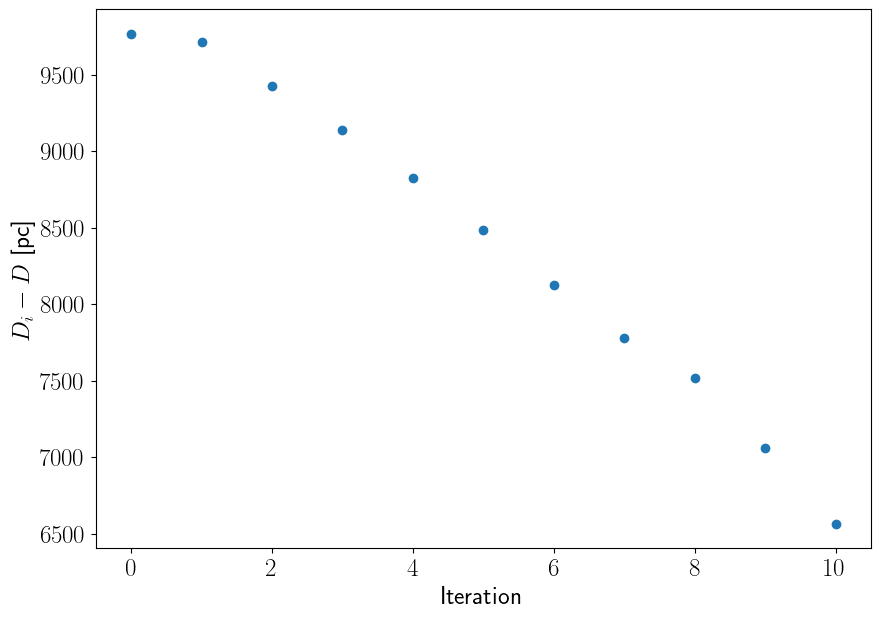

In [177]:
plt.figure(figsize=(10, 7))
plt.scatter(np.arange(len(new_distances)), new_distances - data_ready['dist'][index_test], label='Corrected distance')
plt.xlabel('Iteration')
plt.ylabel('$D_i - D$ [pc]')
plt.show()

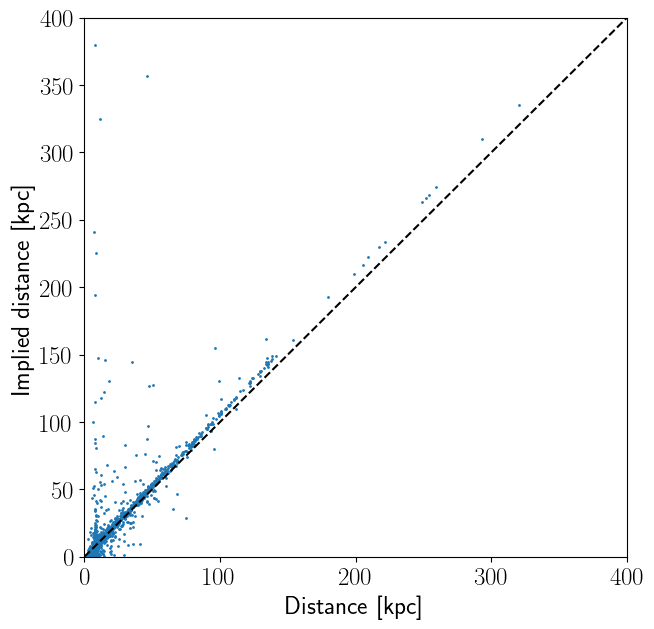

In [64]:
# check the difference
plt.figure(figsize=(7, 7))
plt.scatter(data_ready['dist'], data_ready['implied_distance']/1000, s=1, label='Implied distance')
# plot 1x1 line
plt.plot([0, 400], [0, 400], 'k--', label='1:1 line')
plt.xlim(0, 400)
plt.ylim(0, 400)    
plt.xlabel('Distance [kpc]')
plt.ylabel('Implied distance [kpc]')
plt.show()

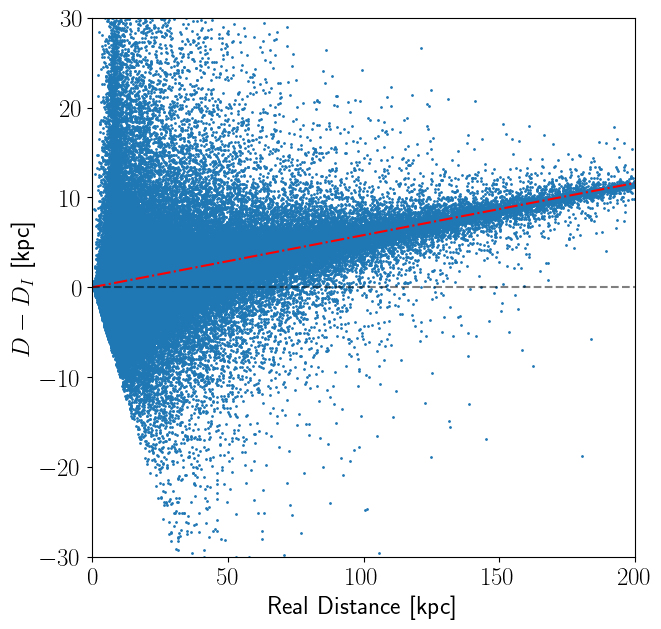

In [161]:
# check the difference
plt.figure(figsize=(7, 7))
plt.scatter(data_ready['dist'], data_ready['implied_distance']/1000 - data_ready['dist'], s=1, alpha = 0.2 ,label='Implied distance')
# plot 1x1 line
#plt.plot([0, 400], [0, 400], 'k--', label='1:1 line')
#plt.xlim(0, 400)
#plt.ylim(0, 400)    
plt.ylim(-30, 30)
plt.xlim(0, 200)
x_dist = np.linspace(0, 200, 100)
y_dist = x_dist*0.058
plt.plot(x_dist, y_dist, 'r-.')
plt.plot([0, 200], [0, 0], 'k--', alpha=0.5)
plt.xlabel('Real Distance [kpc]')
plt.ylabel('$D - D_I$ [kpc]')
plt.show()

In [162]:
np.mean(data_ready['implied_distance']/1000 - data_ready['dist'])

np.float64(4.433906668419893)